# Project: Classification

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn import ensemble 
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn import tree 
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing  import LabelEncoder

sys.path.append('../../')

from DataScienceHelpers.DataCleaningOutliers import find_outliers_iqr
from DataScienceHelpers.DataCleaningOutliers import find_parameters_iqr


## Part 1. Getting to know the data, handling empy data and outliers

### Task 1

In [17]:
# Load data.
df = pd.read_csv('../../data/bank_fin.csv', sep = ';')
print(f'Rows: {df.shape[0]}')
print(f'Cols: {df.shape[1]}')

Rows: 11162
Cols: 17


In [18]:
# Investigate data for empty values. Which columns contains empty values? How many empty values are there?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Task 2

In [19]:
# Are there empty values in the 'job' and 'education' features?
print('Job values by frequency:')
print(df['job'].value_counts())
print('Education by frequency:')
print(df['education'].value_counts())

Job values by frequency:
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
Education by frequency:
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64


Empty values in the fields 'job' and 'education' are marked with the word 'unknown'.

### Task 3

In [20]:
# Convert the 'balance' feature to the float datatype.
def clean_up_balance(x):
    return x if pd.isna(x) else float(str(x)[:-3].replace(' ', '').replace(',', '.'))

df['balance'] = df['balance'].apply(lambda x: clean_up_balance(x))
print(f'Mean balance value: {df['balance'].mean():.3f}')

Mean balance value: 1529.129


### Task 4

In [21]:
# Process the empty values in the 'balance' feature by replacing them with the median value.
median_balance = df['balance'].median()
print(f'Median balance value: {median_balance:.3f}')

df['balance'] = df['balance'].apply(lambda x: median_balance if pd.isna(x) else x)
print(f'Updated mean balance value: {df['balance'].mean():.3f}')

Median balance value: 550.000
Updated mean balance value: 1526.936


### Task 5

In [22]:
# Process empty values in the features 'job' and 'education' by replacing them with the mode value.
job_mode = df['job'].value_counts().index.tolist()[0]
print(f'Job mode value: {job_mode}')

education_mode = df['education'].value_counts().index.tolist()[0]
print(f'Education mode value: {education_mode}')

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

mask_popular_job_education = (df['job'] == job_mode) & (df['education'] == education_mode)
print(f'Mean balance for most popular job and education: {df[mask_popular_job_education]['balance'].mean():.3f}')


Job mode value: management
Education mode value: secondary
Mean balance for most popular job and education: 1598.883


### Task 6

In [23]:
# Delete outliers for the 'balance' feature
print('IQR, lower bound and upper bound found by the Tukey method:')
print(find_parameters_iqr(df, 'balance'))

outliers, df = find_outliers_iqr(df, 'balance')

print(f'Rows without outliers: {df.shape[0]}')

IQR, lower bound and upper bound found by the Tukey method:
(1576.0, -2241.0, 4063.0)
Rows without outliers: 10105


## Part 2: Exploratory data analysis

### Task 1

Value counts for the 'deposit' feature:
deposit
no     5424
yes    4681
Name: count, dtype: int64


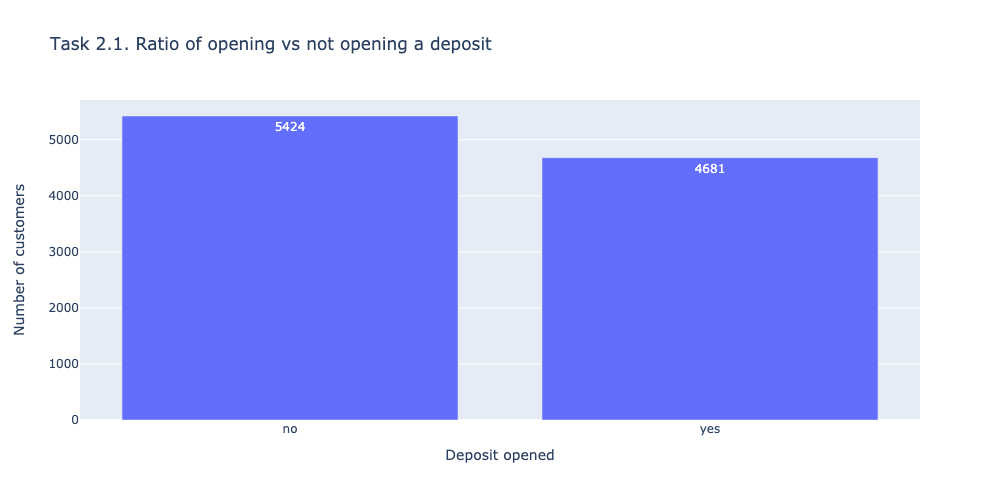

In [35]:
# Investigate the ratio of those who opened a deposit and those who did not do it. Illustrate your results.
print('Value counts for the \'deposit\' feature:')
print(df['deposit'].value_counts())

fig = px.bar(
    df['deposit'].value_counts(),    
    width=1000,
    height=500,
    title='Task 2.1. Ratio of opening vs not opening a deposit',
    text_auto=True
).update_layout(
    yaxis_title='Number of customers',
    xaxis_title='Deposit opened',
    showlegend=False
)
fig.show('png')

The data is slightly imbalanced showing the difference in classes of around 15 %.

### Tasks 2 and 3

In [44]:
# Calculate quantitative statistics for numeric features. Interpret the results.
print('Quantitative statistics of the numeric features:')
print(df.describe())

fig = px.histogram(
    df['age'],
    width=1000,
    height=500,
    title='Tasks 2.2 and 2.3. Age distribution'
).update_layout(
    yaxis_title='Number of customers',
    xaxis_title='Age',
    showlegend=False
)
#fig.show('png')

fig = px.histogram(
    df['balance'],
    width=1000,
    height=500,
    title='Tasks 2.2 and 2.3. Balance distribution'
).update_layout(
    yaxis_title='Number of customers',
    xaxis_title='Balance',
    showlegend=False
)
#fig.show('png')

Quantitative statistics of the numeric features:
                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000    

* Feature 'age': mean is close to median, min and max values are trustworthy for a bank customer, standard deviation and quartiles show that the customers are mainly distributed around the mean/median. Visually the distribution resembles a log normal one.
* Feature 'balance': mean is higher than the median (the values are unproportionally higher on the right side of the distribution), min and max values look trustworthy and the mean is close to the middle between them, standard deviation and quartiles show that the values spread is very high. The histogram shows that a very large amount of customers have a 0 balance.
* Feature 'day': we'll skip this feature because it cannot be considered without the month, which is a textual feature.
* Feature 'duration: mean is higher than the duration (this can be probably explained by many dropped calls), min and max values are trustworthy where min is probably a dropped call, standard deviation and quartiles show that there is a high values spread.

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna